In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 4s 0us/step


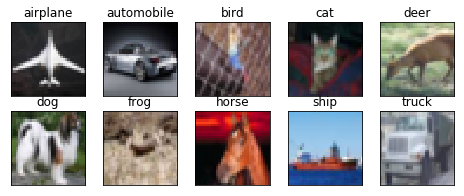

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [7]:
from keras.layers import Input
from keras.models import Model
from keras.layers import DepthwiseConv2D
from keras.layers import SeparableConv2D
from keras.layers import concatenate
from keras.layers import Conv2D
from keras.layers import Lambda
import tensorflow as tf

input_shape = Input(shape=(32,32,3)) #32*32*3

def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2) 
  
def space_to_depth_x4(x):
    return tf.space_to_depth(x, block_size=4)   


#Depthwise Separable Convolution : Depth-wise convolution followed by point wise
layer_1 = SeparableConv2D(32,5,border_mode='same',name='Sep_Conv_01')(input_shape)
layer_1 = BatchNormalization(name='Batch_norm1')(layer_1)
layer_1 = Activation('relu',name='relu_01')(layer_1)

skip_connect_layer1 = layer_1 #Input to the layers 4,6,8,10, MP1,MP2

#Normal convolution 5*5
layer_2 = Conv2D(32,5,5,border_mode='same',name='Normal_Conv_02')(layer_1)
layer_2 = BatchNormalization(name='Batch_norm_02')(layer_2)
layer_2 = Activation('relu',name='relu_02')(layer_2)

skip_connect_layer2 = layer_2 #Input to the layers 10,11

#Normal convolution 5*5
layer_3 = Conv2D(32,5,5,border_mode='same',name='Normal_Conv_03')(layer_2)
layer_3 = BatchNormalization(name='Batch_norm_03')(layer_3)
layer_3 = Activation('relu',name='relu_03')(layer_3)

skip_connect_layer3 = layer_3 #Input to the layers 7,8,11,12


#Concatenate Layer 1 & 3
layer_3 = concatenate([layer_3,skip_connect_layer1],axis=-1)

  
#Depthwise Separable Convolution : Depth-wise convolution followed by point wise
layer_4 = SeparableConv2D(32,5,border_mode='same',name='Sep_Conv_02')(layer_3)
layer_4 = BatchNormalization(name='Batch_norm_04')(layer_4)
layer_4 = Activation('relu',name='relu_04')(layer_4)

skip_connect_layer4 = layer_4 #Input to the layers 6,7,8,10,11,12,MP2.SoftMax


#Concatenate Layer 1 & 3
layer_4 = concatenate([layer_4,skip_connect_layer1],axis=-1)

max_pool_layer_1 = MaxPooling2D(pool_size=(2,2))(layer_4) 

#Depthwise Separable Convolution : Depth-wise convolution followed by point wise
layer_5 = SeparableConv2D(32,3,border_mode='same',name='Sep_Conv_03')(max_pool_layer_1)
layer_5 = BatchNormalization(name='Batch_norm_05')(layer_5)
layer_5 = Activation('relu',name='relu_05')(layer_5)

skip_connect_layer5 = layer_5 #Input to the layers 7,8,11,12,MP2


#Change the layer resolution for layer 1 and layer 4
layer_1_to_6 = Lambda(space_to_depth_x2)(skip_connect_layer1)
layer_4_to_6 = Lambda(space_to_depth_x2)(skip_connect_layer4)

layer_5_new = concatenate([layer_5,layer_1_to_6,layer_4_to_6],axis=-1)




#Normal convolution 5*5
layer_6 = Conv2D(32,5,5,border_mode='same',name='Normal_Conv_04')(layer_5_new)
layer_6 = BatchNormalization(name='Batch_norm_06')(layer_6)
layer_6 = Activation('relu',name='relu_06')(layer_6)

skip_connect_layer6 = layer_6 


#Change the layer resolution for layer 4
layer_4_to_7 = Lambda(space_to_depth_x2)(skip_connect_layer4)
layer_6_new = concatenate([layer_6,layer_4_to_7,skip_connect_layer5],axis=-1)


#Depthwise Separable Convolution : Depth-wise convolution followed by point wise
layer_7 = SeparableConv2D(32,3,border_mode='same',name='Sep_Conv_04')(layer_6_new)
layer_7 = BatchNormalization(name='Batch_norm_07')(layer_7)
layer_7 = Activation('relu',name='relu_07')(layer_7)
skip_connect_layer7 = layer_7 


#Change the layer resolution for layer 1, layer 4, layer 3, and concatenate with layer 5, layer 6, layer_7

layer_1_to_8 = Lambda(space_to_depth_x2)(skip_connect_layer1)
layer_3_to_8 = Lambda(space_to_depth_x2)(skip_connect_layer3)
layer_4_to_8 = Lambda(space_to_depth_x2)(skip_connect_layer4)

layer_7_new = concatenate([layer_7,layer_5,layer_6,layer_1_to_8,layer_3_to_8,layer_4_to_8],axis=-1)



#Depthwise Separable Convolution : Depth-wise convolution followed by point wise
layer_8 = SeparableConv2D(32,5,border_mode='same',name='Sep_Conv_05')(layer_7_new)
layer_8 = BatchNormalization(name='Batch_norm_08')(layer_8)
layer_8 = Activation('relu',name='relu_08')(layer_8)
skip_connect_layer8 = layer_8


#Change the layer resolution for layer 1, layer 4 and concatenate it with layer7, layer 5
layer_1_to_max2 = Lambda(space_to_depth_x2)(skip_connect_layer1)
layer_4_to_max2 = Lambda(space_to_depth_x2)(skip_connect_layer4)


layer_8_new = concatenate([layer_8,layer_5,layer_7,layer_1_to_max2,layer_4_to_max2],axis=-1)



max_pool_layer_2 = MaxPooling2D(pool_size=(2,2))(layer_8_new)

#Change resolutionf for Layer 6
layer_6_to_9 = Lambda(space_to_depth_x2)(skip_connect_layer6)

max_pool_layer_2_new = concatenate([max_pool_layer_2,layer_6_to_9],axis=-1)


#Normal convolution 5*5
layer_9 = Conv2D(32,5,border_mode='same',name='Normal_Conv_05')(max_pool_layer_2_new)
layer_9 = BatchNormalization(name='Batch_norm_09')(layer_9)
layer_9 = Activation('relu',name='relu_09')(layer_9)

skip_connect_layer9 = layer_9

#Change the resolution for layer-7, layer-2, layer-1, layer-9
layer_1_to_10 = Lambda(space_to_depth_x4)(skip_connect_layer1)
layer_2_to_10 = Lambda(space_to_depth_x4)(skip_connect_layer2)
layer_7_to_10 = Lambda(space_to_depth_x2)(skip_connect_layer7)

layer_9_new = concatenate([layer_9,layer_1_to_10,layer_2_to_10,layer_7_to_10],axis=-1)

#Depthwise Separable Convolution : Depth-wise convolution followed by point wise
layer_10 = SeparableConv2D(32,5,border_mode='same',name='Sep_Conv_06')(layer_9_new)
layer_10 = BatchNormalization(name='Batch_norm_10')(layer_10)
layer_10 = Activation('relu',name='relu_10')(layer_10)

skip_connect_layer10 = layer_10

#Change the resolution of layers from layer_3,layer_2,layer_5 and concatenate with layer_9 and layer_10

layer_2_to_11 = Lambda(space_to_depth_x4)(skip_connect_layer2)
layer_3_to_11 = Lambda(space_to_depth_x4)(skip_connect_layer3)
layer_5_to_11 = Lambda(space_to_depth_x2)(skip_connect_layer5)

layer_10_new = concatenate([layer_2_to_11,layer_3_to_11,layer_5_to_11,skip_connect_layer9,skip_connect_layer10],axis=-1)

#Normal convolution 3*3
layer_11 = Conv2D(32,3,border_mode='same',name='Normal_Conv_06')(layer_10_new)
layer_11 = BatchNormalization(name='Batch_norm_11')(layer_11)
layer_11 = Activation('relu',name='relu_11')(layer_11)

skip_connect_layer11 = layer_11


#Change the resolution of layers from layer_4, layer_5, layer_7, layer_3 and concatenate it with layer_10,layer_11
layer_3_to_12 = Lambda(space_to_depth_x4)(skip_connect_layer3)
layer_4_to_12 = Lambda(space_to_depth_x4)(skip_connect_layer4)
layer_5_to_12 = Lambda(space_to_depth_x2)(skip_connect_layer5)
layer_7_to_12 = Lambda(space_to_depth_x2)(skip_connect_layer7)

layer_11_new = concatenate([layer_3_to_12,layer_4_to_12,layer_5_to_12,layer_7_to_12,skip_connect_layer10,skip_connect_layer11],axis=-1)

#Depthwise Separable Convolution : Depth-wise convolution followed by point wise
layer_12 = SeparableConv2D(32,5,border_mode='same',name='Sep_Con_10')(layer_11_new)
layer_12 = BatchNormalization(name='Batch_norm_12')(layer_12)
layer_12 = Activation('relu',name='relu_12')(layer_12)


#################

layer_12 = SeparableConv2D(32,5,border_mode='same',name='Sep_Con_10')(layer_11_new)
layer_12 = BatchNormalization(name='Batch_norm_12')(layer_12)
layer_12 = Activation('relu',name='relu_12')(layer_12)
print("#####@@@@@@@@@@@@@@@######")
print(layer_12.shape)


#Change the resolution of layers from layer_10,layer_7,layer_4
layer_4_to_soft = Lambda(space_to_depth_x4)(skip_connect_layer4)
layer_7_to_soft = Lambda(space_to_depth_x2)(skip_connect_layer7)

layer_12_new = concatenate([layer_4_to_soft,layer_7_to_soft,skip_connect_layer10,layer_12],axis=-1)
layer_12_new2 = Convolution2D(10,(8,8))(layer_12)

#Flatten = Layer
flayer = Flatten()(layer_12_new2)
predictions = Activation('softmax')(flayer)




W0623 00:43:38.875065 140564593543040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0623 00:43:38.912093 140564593543040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, 5, name="Sep_Conv_01", padding="same")`
W0623 00:43:38.924743 140564593543040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0623 00:43:38.974638 140564593543040 deprecation_wrapper.py:119] From /usr/local/lib/pyth

#####@@@@@@@@@@@@@@@######
(?, 8, 8, 32)


In [8]:
model = Model(inputs=input_shape, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

W0623 00:43:43.101954 140564593543040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
Sep_Conv_01 (SeparableConv2D)   (None, 32, 32, 32)   203         input_1[0][0]                    
__________________________________________________________________________________________________
Batch_norm1 (BatchNormalization (None, 32, 32, 32)   128         Sep_Conv_01[0][0]                
__________________________________________________________________________________________________
relu_01 (Activation)            (None, 32, 32, 32)   0           Batch_norm1[0][0]                
__________________________________________________________________________________________________
Normal_Con

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=97, epochs=100)`
  # This is added back by InteractiveShellApp.init_path()
W0623 00:43:43.291087 140564593543040 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_di

Epoch 1/100
97/97 [==============================] - 42s 436ms/step - loss: 1.6522 - acc: 0.4211 - val_loss: 1.5427 - val_acc: 0.4405
Epoch 2/100
97/97 [==============================] - 34s 355ms/step - loss: 1.1332 - acc: 0.5980 - val_loss: 1.9274 - val_acc: 0.3710
Epoch 3/100
97/97 [==============================] - 33s 344ms/step - loss: 0.9234 - acc: 0.6772 - val_loss: 1.1365 - val_acc: 0.6025
Epoch 4/100
97/97 [==============================] - 34s 348ms/step - loss: 0.7967 - acc: 0.7241 - val_loss: 1.2222 - val_acc: 0.5907
Epoch 5/100
97/97 [==============================] - 34s 354ms/step - loss: 0.7010 - acc: 0.7545 - val_loss: 1.1868 - val_acc: 0.6183
Epoch 6/100
97/97 [==============================] - 35s 357ms/step - loss: 0.6139 - acc: 0.7878 - val_loss: 0.9993 - val_acc: 0.6710
Epoch 7/100
97/97 [==============================] - 35s 360ms/step - loss: 0.5285 - acc: 0.8201 - val_loss: 1.0948 - val_acc: 0.6485
Epoch 8/100
97/97 [==============================] - 35s 361ms

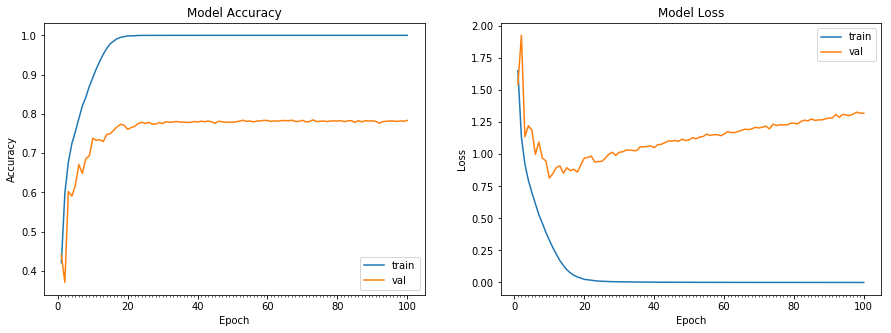

Accuracy on test data is: 78.35


In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.25* epoch), 10)

datagen = ImageDataGenerator(zoom_range=0.0,rotation_range=3,horizontal_flip=False)

# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 512),samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels),callbacks=[LearningRateScheduler(scheduler)], verbose=1)

plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))
